In [ ]:
# Copyright Andrew Selle 
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
# http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import wavefile
import scipy
import scipy.fftpack 
import scipy.signal
from scipy.signal import fftconvolve, convolve, kaiser
from scipy.signal import hamming
import numpy as np

In [11]:
#log = wavefile.loadWave("LogSweep_800_22000_44k_16-bit_L.wav")
#log2 = wavefile.loadWave("LogSweep_800_22000_44k_16-bit_L2.wav")
record = wavefile.loadWave("sweep_rec.wav")
print(record)
import matplotlib.pylab as pylab


(44100, array([[ 0.0000000e+00,  3.0517578e-05, -3.0517578e-05, ...,
        -3.0517578e-05,  3.0517578e-05, -3.0517578e-05]], dtype=float32))


In [12]:
fs = 44100
fstart = 2*np.pi*20.
fend = 2*np.pi*22000.
T = 3
t = np.arange(fs*T) / fs
arg = fstart * T / np.log(fend/fstart) * np.exp(t/T * np.log(fend/fstart))-1
win = kaiser(2048, 18) # NOT
sweep = -np.sin(arg)
sweep[:win.shape[0]//2] *= win[:win.shape[0]//2]
sweep[-win.shape[0]//2:] *= win[-win.shape[0]//2:]
# inverse filter
amp_end = np.log(10**(-6 * np.log(fend/fstart)/np.log(2)/ 20))
amp = np.exp(np.arange(fs*T) / (fs*T) * amp_end)
filt = sweep[::-1] * amp
self_convolve = fftconvolve(filt, sweep)
self_convolve_fft = scipy.fftpack.fft (self_convolve)
filt /= np.abs(self_convolve_fft[self_convolve_fft.shape[0]//4])
#f, t, Sxx = scipy.signal.spectrogram(record[1][0])
#pylab.pcolormesh(t, f, Sxx, shading='gouraud')
sweepForSave = sweep[None,:]
writer = wavefile.WaveWriter("sweep.wav", fs, 1)
writer.write(sweepForSave)


132300

In [13]:
#pylab.plot(filt)
#pylab.plot(sweep)

In [14]:
def Spectrum(s, calibration=None, one_over_octaves=None):
    fft = scipy.fftpack.fft(s)
    freq = scipy.fftpack.fftfreq(s.size, d=1./fs)
    n = round(s.shape[0]/2)
    xf = freq[:n]
    mag = np.abs(fft[0:n])
    print(xf)
    if one_over_octaves:
        magnew = []
        for idx, v in enumerate(mag):
            freqs = (1 - 3/2. / (one_over_octaves*2)) * xf[idx], xf[idx] * (1+1/(one_over_octaves*2))
            idxs = np.searchsorted(xf, freqs[0], side='left'), np.searchsorted(xf, freqs[1], side='right')
            foo = mag[idxs[0]: idxs[1]]
            vals = np.sum(foo) / (idxs[1]-idxs[0])
            magnew.append(vals)
        mag = magnew
    dB = 20*np.log10(mag)
    
    if calibration is not None:
        dB -= 1*np.interp(xf, calibration[:,0], calibration[:,1])
    return xf, dB

In [15]:
#pylab.plot(*Spectrum(convolve(sweep,filt)))

[0.000000e+00 1.250000e+00 2.500000e+00 ... 2.204625e+04 2.204750e+04
 2.204875e+04]


Text(0.5, 0, 'Time (s)')

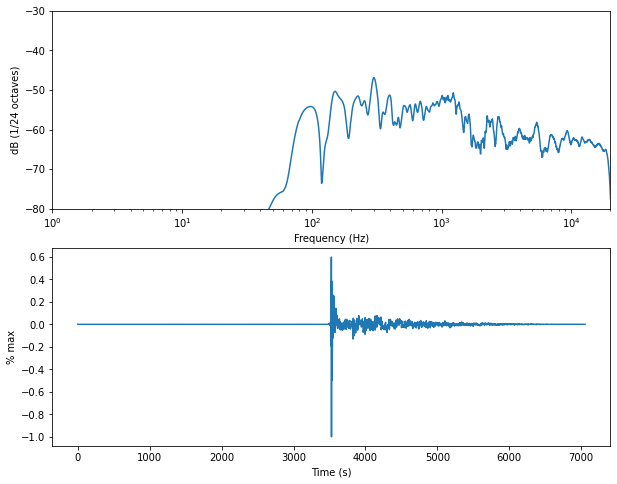

In [16]:
calibration = np.array([[float(t) for t in x.replace("\n","").split("\t")] for x in open("7026409.txt").readlines()[1:-1]])
#print(calibration[:,0])
assert(fs == record[0])
impulse = fftconvolve(np.concatenate([np.zeros(shape=record[1][0].shape),record[1][0]]),filt)
time = record[1].shape[1] / record[0]
center = np.argmax(np.abs(impulse))

window = int(0.080 * record[0])
impulse_window = impulse[center-window:center+window]
window_filter =  hamming(impulse_window.shape[0])
window_filter /= np.linalg.norm(window_filter)
impulse_window *= window_filter
impulse_window_pad = np.concatenate([np.zeros(impulse_window.size*2),impulse_window, np.zeros(impulse_window.size*2)])

pylab.figure(figsize=(10,8))
pylab.subplot(2,1,1)
octaves = 24
pylab.plot( *Spectrum(impulse_window_pad, calibration, octaves),'-')
pylab.xlim(1,20000)
pylab.ylim(-80,-30)
pylab.ylabel("dB (1/%d octaves)" % octaves)
pylab.xlabel("Frequency (Hz)")

pylab.semilogx()
pylab.subplot(2,1,2)
pylab.plot(impulse_window / np.max(np.abs(impulse_window)))
pylab.ylabel("% max")
pylab.xlabel("Time (s)")


In [ ]:
lambda = 2./3
